<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/01_mining_detection_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diccionario de datos**
---
- `Name`: nombre de la ventana de tiempo.
- `Netflows`: cantidad de netflows en la ventana de tiempo.
- `First_Protocol`: top 1 de protocolos usados en la ventana de tiempo.
- `Second_Protocol`: top 2 de protocolos usados en la ventana de tiempo.
- `Third_Protocol`: top 3 de protocolos usados en la ventana de tiempo.
- `p1_d`: 25% de los percentiles de todas las duraciones en la ventana de tiempo
- `p2_d`: 50% de los percentiles de todas las duraciones en la ventana de tiempo
- `p3_d`: 75% de los percentiles de todas las duraciones en la ventana de tiempo
- `duration`: duración total de la ventana de tiempo
- `max_d`: valor máximo de todas las duraciones en la ventana de tiempo.
- `min_d`: valor mínimo de todas las duraciones en la ventana de tiempo.
- `#packets`: número total de paquetes en la ventana de tiempo.
- `Avg_bps`: promedio de bits por segundo en la ventana de tiempo.
- `Avg_pps`: promedio de paquetes por segundo en la ventana de tiempo.
- `Avg_bpp`: promedio de bytes por paquete en la ventana de tiempo.
- `#Bytes`: número total de bytes en la ventana de tiempo.
- `#sp`: número total de puertos de origen usados en la ventana de tiempo.
- `#dp`: número total de puertos de destino usados en la ventana de tiempo.
- `first_sp`: top 1 de los puertos de origen en la ventana de tiempo.
- `second_sp`: top 2 de los puertos de origen en la ventana de tiempo.
- `third_sp`: top 3 de los puertos de origen en la ventana de tiempo.
- `first_dp`: top 1 de los puertos de destino en la ventana de tiempo.
- `second_dp`: top 2 de los puertos de destino en la ventana de tiempo.
- `third_dp`: top 3 de los puertos de destino en la ventana de tiempo.
- `p1_ip`: 25% de los percentiles de todas las entradas de paquetes en la ventana de tiempo.
- `p2_ip`: 50% de los percentiles de todas las entradas de paquetes en la ventana de tiempo.
- `p3_ip`: 75% de los percentiles de todas las entradas de paquetes en la ventana de tiempo.
- `p1_ib`: 25% de los percentiles de todas las entradas de bytes en la ventana de tiempo.
- `p2_ib`: 50% de los percentiles de todas las entradas de bytes en la ventana de tiempo.
- `p3_ib`: 75% de los percentiles de todas las entradas de bytes en la ventana de tiempo.
- `Type`: tipo de ventana de tiempo
  - benignas: 0
  - bitcash: 1
  - bitcoin: 2
  - ethereum: 3
  - monero: 4
  - litecoin: 5

# **Contexto**
---
El software de minería puede usarse en forma de malware, para que un cibercriminal mine con los recursos de una víctima, lo cual puede ser costoso en energía eléctrica y en hardware, ya que minar puede degradarlo. Por lo anterior, se resalta que las muestras de los mineros fueron realizados en ambientes seguros y con duración de 5 minutos por ejecución.

Se utilizó un esnifer como Wireshark, del cual se obtuvieron archivos en formato pcaps, los cuales fueron procesados por una sonda llamada netfdump, para extraer la información. Esa información venía por flujos relacionados al archivo PCAPS, por lo tanto, se aplicó un concepto de ventana de tiempos de trabajos relacionados con botnes, para resumir estos flujos.

# **Conceptos**
---
- **Prueba de trabajo** problema matemático (no útil) que se debe resolver para minar una criptomoneda. Por cada moneda descubierta debe aumentar la complejidad.

- **flujo** conexión y transferencia de información entre un emisor y receptor.

- **Ventanas de tiempo** resumen de flujos de red, en este conjunto de datos cada registro es un resumen de flujos por archivo. Un archivo pcap puede tener mas de un grupos de flujos.

In [1]:
def optimization_learning_curves(history, metrica, title: str= '', x_size:int=8, y_size:int=4, 
                                 font_size:int=15, x_label:str='Epoch',y_label:str='Loss')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(title, fontsize = font_size)
  ax.plot(history.history[metrica])
  ax.plot(history.history[f'val_{metrica}'])
  ax.set_xlabel(x_label, size = 12)
  ax.set_ylabel(y_label, size = 12)
  ax.legend(['Train', 'Test'], loc = 'upper left', fontsize = 12)
  ax.tick_params(labelsize = 12)
  fig.show()

In [2]:
def metricas(validation, prediction, matrix, label:list=[1])->None:
  accuracy = '%.3f' % metrics.accuracy_score(validation, prediction)
  kappa = '%.3f' % metrics.cohen_kappa_score(validation, prediction)
  precision = '%.3f' % metrics.precision_score(validation, prediction, labels=label, average="macro")
  recall = '%.3f' % metrics.recall_score(validation, prediction, labels=label, average="macro")
  f1_score = '%.3f' % metrics.f1_score(validation, prediction, labels=label, average="macro")

  print(f'Accuracy  :   {accuracy}')
  print(f'Kappa     :   {kappa}')
  print(f'predicción Miners')
  print(f'Precision:   {precision}')
  print(f'Recall    :   {recall}')

  VN, FP = 0, 0 
  if label == [1]:
    VN = matrix[0,0]
    FP = matrix[0,1]
  else:
    VN = matrix[0,0]
    FP = matrix[0,1]
  specificity = VN/(VN+FP)
  specificity = '%.3f' %  specificity

  #print(f'Specificity:   {specificity}')
  print(f'F1-score   :   {f1_score}')
  return accuracy, kappa, precision, recall, f1_score

In [3]:
def consufion_matrix(validation, prediction, title: str= 'Matriz de confusion', 
                     x_size:int=6, y_size:int=5, **kwards):
  matrix = metrics.confusion_matrix(validation, prediction)
  fig, ax = plt.subplots(nrows= 1, ncols=  1, figsize = (x_size,y_size))
  sns.heatmap(matrix, annot=True, ax = ax, cmap=plt.cm.Blues, fmt = 'g', annot_kws={'size': 13})
  ax.set_title(title, size = 13)
  v = list(kwards.values())
  k = list(kwards.keys())

  if ax.get_xticklabels()[0].get_text() == v[0]:
    ax.xaxis.set_ticklabels([k[0], k[1]])
    ax.yaxis.set_ticklabels([k[0], k[1]])
  else:
    ax.xaxis.set_ticklabels([k[1], k[0]])
    ax.yaxis.set_ticklabels([k[1], k[0]])
  ax.tick_params(labelsize = 13)
  fig.show()
  return matrix

In [4]:
def plot_bars(data, title: str= 'feature', x_size:int=6, y_size:int=5, 
              font_size:int=15):
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(f'Count plot {title}', fontsize = font_size)
  sns.countplot(x = data, ax = ax)
  len_data = data.shape[0]

  for p in ax.patches:
    height = int(p.get_height())
    porc = '{0:.2f}%'.format(height/len_data)
    plt.text(p.get_x()+p.get_width()/2., height-height*0.05, porc, ha="center", backgroundcolor='y')

In [5]:
def unique_value(data, feature):
  mp = map(lambda x: data[x].unique().shape[0],feature_object)
  print('Datos unicos por columnas')
  for i in zip(feature, mp):
    print(f'{i}')

In [6]:
def label_encoder_train_test(y_train, y_test):
  encoder_label = LabelEncoder()
  y_train_prep = encoder_label.fit_transform(y_train)
  y_test_prep = encoder_label.fit_transform(y_test)
  return y_train_prep, y_test_prep

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics

# **Data**
---

In [8]:
data = pd.read_csv('https://raw.githubusercontent.com/Kaiziferr/datasets/main/cryptojacking.csv').drop(['Unnamed: 0', 'Name'], axis = 1)
data.head(3)

,Netflows,First_Protocol,Second_Protocol,Third_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,...,first_dp,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type
0,65,TCP,UDP,NaN,18.939,168.173,194.287,7845.126,244.362,0.0,...,443,80.0,123.0,3.0,7.0,22.0,127.0,255.0,1888.00,0
1,18,UDP,TCP,NaN,0.000,0.000,0.000,0.086,0.044,0.0,...,443,53.0,53195.0,1.0,1.0,1.0,37.0,47.0,64.00,0
2,10,UDP,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.0,...,53,39308.0,54454.0,1.0,1.0,1.0,34.0,43.0,61.75,0


Se cambia el valor benigno a otro, ya que no se puede garantizar con certeza que los registros benignos internamente no tengan presencia de otro malware, aunque se puede asegurar que dicha eventualidad sea mínima, ya que, los sitios fueron tomados del top Alexa, además que las URL fueron procesadas por virus total. El registro de red fue capturado en la página principal.

In [9]:
data['Type'] = data['Type'].map({0:'normal', 1:'bitcash', 2:'bitcoin', 3:'ethereum', 4:'monero', 5:'litecoin'})

**Eliminar columnas**
se procede a eliminar la columna Second_Protocol y Third_Protocol, puesto que tienen un porcentaje alto de valores ausentes. 78% y 99% respectivamente. El porcentaje existente es muy bajo, para asumir una imputación de indicadores de tendencia central como la moda.

In [10]:
data = data.drop(['Second_Protocol', 'Third_Protocol'], axis=1)

También se elimina las columnas third_sp y third_dp por tener un amplio número de valores faltantes. Más precisamente 72% de valores nulos.

In [11]:
data = data.drop(['third_sp', 'third_dp'], axis = 1)

**Cambio de tipo de dato**
los puertos, si bien son representados por números, su naturaleza es categórica. Por lo tanto, variables como first_sp, second_sp, third_sp, first_dp y third_dp deben ser categóricas, ya que refleja un top de un valor usado, pero no aplica una propiedad de orden, puesto que es indiferente si se utiliza el puerto 80 o el 90.

In [12]:
data['first_sp'] = data['first_sp'].astype('object')
data['second_sp'] = data['second_sp'].astype('object')
data['first_dp'] = data['second_dp'].astype('object')
data['second_dp'] = data['second_dp'].astype('object')

**Imputación de valores ausentes**
imputación de los valores de las caracteristicas 'second_sp', 'second_dp' deben hacerse con el indicador de frecuencia categorico como la moda 


In [13]:
punter = data[['second_sp', 'second_dp']]
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
value = imputer.fit_transform(punter)

In [14]:
punter = pd.DataFrame(value, columns = punter.columns)
data['second_sp'] = punter['second_sp']
data['second_dp'] = punter['second_dp']
data.head(2)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,second_sp,first_dp,second_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type
0,65,TCP,18.939,168.173,194.287,7845.126,244.362,0.0,5546,125708,...,80.0,80.0,80.0,3.0,7.0,22.0,127.0,255.0,1888.0,normal
1,18,UDP,0.000,0.000,0.000,0.086,0.044,0.0,20,148,...,53195.0,53.0,53.0,1.0,1.0,1.0,37.0,47.0,64.0,normal


Se anexa una característica que indica el tipo de registro con relación a si es minero o normal.

In [15]:
data['is_miner'] = 0
data.iloc[696:, -1] = 1 
data['is_miner'] = data['is_miner'].astype('object')

In [16]:
data.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,first_dp,second_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,is_miner
0,65,TCP,18.939,168.173,194.287,7845.126,244.362,0.0,5546,125708,...,80.0,80.0,3.0,7.0,22.0,127.0,255.0,1888.0,normal,0


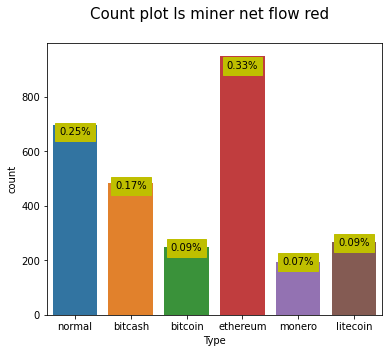

In [17]:
plot_bars(data['Type'], 'Is miner net flow red')

El enfoque por tipo, es un conjunto de datos desbalanceado multicategorico

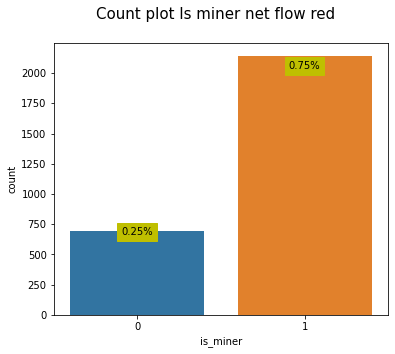

In [18]:
plot_bars(data['is_miner'], 'Is miner net flow red')

Si el enfoque del estudio es para esta característica, el conjunto queda desbalanceado, ya que el 25% de los datos es para registros normales y el resto es para datos mineros.

In [19]:
feature_object = data.select_dtypes(include=['object', 'category']).columns

In [20]:
unique_value(data, feature_object)

Datos unicos por columnas
('First_Protocol', 2)
('first_sp', 73)
('second_sp', 294)
('first_dp', 289)
('second_dp', 288)
('Type', 6)
('is_miner', 2)


las presentes variables categoricas 
- first_sp
- second_sp
- first_dp
- second_dp

Presentan varios valores unicos, si bien pudiera contribuir en la predicción o aporta información sobre registros de minería, hay que tener en cuenta que los puertos pueden ser configurados por el atacante, por lo tanto, la información de estás variables es producto de la configuración en la toma de registros, por lo tanto, tenerlas en cuenta podría generar sesgo en los modelos. Por lo anterior, se procede a ignorar estas variables al momento de encodizar.

In [21]:
data = data.drop(['first_sp', 'second_sp', 'first_dp', 'second_dp'], axis = 1)

# **Copia de los datos**


In [22]:
data_copia = data

# **Enfoque**

- Descripción:  prediccion de mineros por la naturaleza de su trafico. 
- Problema de clasificación
- Problema dicotomico
- Variable a predecir




Para el enfoque es necesario ignorar la variable del tipo de minería. Pues la variable es redundande para el enfoque o tipo de problema.

In [23]:
data.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'Type', 'is_miner'],
      dtype='object')

In [24]:
data.head(2)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,#sp,#dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,is_miner
0,65,TCP,18.939,168.173,194.287,7845.126,244.362,0.0,5546,125708,...,33,37,3.0,7.0,22.0,127.0,255.0,1888.0,normal,0
1,18,UDP,0.000,0.000,0.000,0.086,0.044,0.0,20,148,...,13,8,1.0,1.0,1.0,37.0,47.0,64.0,normal,0


In [25]:
X = data.iloc[:, 0:-2]
y = data['is_miner'].astype('int')

# **Aplicar un submuestreo**

El conjunto de datos que se analiza, proviene de una sonda, la cual para la fecha se me desconfiguro, por lo tanto, no puedo procesar tráfico normal, el cual es mucho mayor al tráfico minero, por lo tanto, sub muestreo, para que el tráfico sea muy cercano a una data balanceada, puesto que el interés del estudio es relacionado con encontrar tráfico minero.

1. Se separa los datos mineros y el normal

In [26]:
data_normal = data[data['is_miner']==0]
data_miner = data[data['is_miner'] == 1]

2. se aleatoriza el data minero

In [27]:
data_miner = data_miner.reset_index()
data_miner = data_miner.iloc[np.random.RandomState(seed=1478).permutation(data_miner.index)]

In [28]:
data_miner

,index,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,...,#sp,#dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,is_miner
444,1140,2,TCP,288.42525,288.4255,288.42575,576.851,288.426,288.425,19,...,2,2,9.25,9.5,9.75,2137.25,3969.5,5801.75,bitcash,1
1640,2336,2,TCP,309.61600,309.6160,309.61600,619.232,309.616,309.616,394,...,2,2,190.00,197.0,204.00,18178.50,26820.0,35461.50,ethereum,1
859,1555,2,TCP,548.91225,548.9225,548.93275,1097.845,548.943,548.902,625,...,2,2,300.75,312.5,324.25,28614.75,42416.5,56218.25,ethereum,1
1969,2665,2,TCP,241.98025,244.1485,246.31675,488.297,248.485,239.812,36,...,2,2,17.00,18.0,19.00,3187.50,5450.0,7712.50,litecoin,1
695,1391,4,TCP,0.02175,76.1155,152.21225,304.474,152.243,0.000,20,...,2,2,2.00,4.0,7.00,40.00,80.0,2298.00,bitcoin,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,1629,10,TCP,10.38475,13.2640,90.45925,440.597,106.601,0.000,265,...,2,2,6.25,8.5,54.50,472.25,1546.5,2699.00,ethereum,1
1630,2326,2,TCP,297.51000,297.5510,297.59200,595.102,297.633,297.469,368,...,2,2,179.00,184.0,189.00,16440.00,24774.0,33108.00,ethereum,1
331,1027,2,TCP,281.08250,281.0830,281.08350,562.166,281.084,281.082,22,...,2,2,11.00,11.0,11.00,2873.75,5527.5,8181.25,bitcash,1
710,1406,2,TCP,242.15525,242.1555,242.15575,484.311,242.156,242.155,29,...,2,2,14.25,14.5,14.75,3483.75,6509.5,9535.25,bitcoin,1


3. submuestreo en los datos mineros

In [29]:
temp_X = data_miner.drop(['Type'], axis = 1)
temp_y = data_miner['Type']

In [30]:
X_miner, X_sobrante, y_miner, y_sobrante = train_test_split(temp_X, temp_y, train_size=0.35, shuffle=True, stratify=temp_y, random_state=1234)

In [31]:
data_miner = pd.concat([X_miner.iloc[:,:-1], y_miner, X_miner['is_miner']], axis = 1)

- Se valida tener un porción del muestreo similiar a la forma en que se distribuyen los registros por type de la muestra original

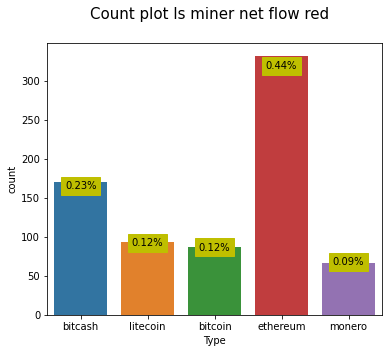

In [32]:
plot_bars(data_miner['Type'], 'Is miner net flow red')

4. Se concatena el conjunto normal y el minero nuevamente.

In [33]:
data = pd.concat([data_miner, data_normal], axis = 0).drop('index', axis = 1)

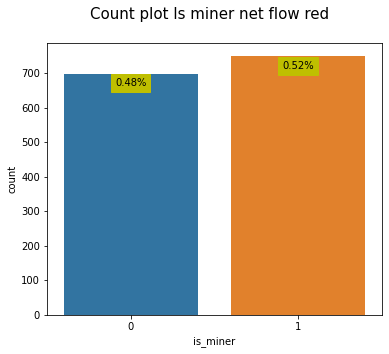

In [34]:
plot_bars(data['is_miner'], 'Is miner net flow red')

- Se aprecia que existe un desbalance, pero no es tán critico

In [35]:
X = data.iloc[:, 0:-1]
y = data.iloc[:,-1]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, stratify=data['Type'], random_state=1234)

**preprocesamiento**
Se estandariza las variables cuantitativas y aplico un codificador a variables categóricas.

In [37]:
def preprocesamiento(X_train, X_test):
  numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
  cat_columns = X_test.select_dtypes(include=['object', 'category']).columns.to_list()
  preprocessor = ColumnTransformer(
      [
          ('scale', StandardScaler(), numeric_columns),
          ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_columns)
      ], remainder='passthrough'
  )
  return preprocessor, numeric_columns, cat_columns

In [38]:
preprocessor, numeric_columns, cat_columns = preprocesamiento(X_train, X_test)

In [39]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_columns)
labels = np.concatenate([numeric_columns, encoded_cat])

In [40]:
data_train_prep = pd.DataFrame(X_train_prep, columns=labels)
data_test_prep = pd.DataFrame(X_test_prep, columns=labels)

In [41]:
y_train_prep, y_test_prep = label_encoder_train_test(y_train, y_test)

Se validaran los mejores predictores antes de ejcutar los modelos


In [42]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression, chi2, SelectFromModel

def the_best_features(X, y):
  clf = ExtraTreesClassifier(n_estimators = 36)
  clf = clf.fit(X,y)
  model = SelectFromModel(clf, prefit=True)
  best_features = X[X.columns[model.get_support(indices = True)]].columns
  return best_features

In [43]:
the_best_features(data_train_prep, y_train_prep)

Index(['p1_d', 'min_d', 'p2_ib', 'Type_ethereum', 'Type_normal'], dtype='object')

In [44]:
the_best_features(data_train_prep, y_train_prep)

Index(['p1_d', 'p2_d', 'min_d', 'Type_ethereum', 'Type_normal'], dtype='object')

In [45]:
the_best_features(data_train_prep, y_train_prep)

Index(['p1_d', 'p2_d', 'min_d', 'Avg_bpp', '#dp', 'Type_ethereum',
       'Type_normal'],
      dtype='object')

Se seleccionan las mejores caracteristicas despues de ejecutar el metodo the_best_features en varias interacciones.

- p1_d: 25% de los percentiles de todas las duraciones en la ventana de tiempo
- p2_d: 50% de los percentiles de todas las duraciones en la ventana de tiempo
- p3_d: 75% de los percentiles de todas las duraciones en la ventana de tiempo
- min_d: valor mínimo de todas las duraciones en la ventana de tiempo.
- max_d: valor máximo de todas las duraciones en la ventana de tiempo.
- Avg_bpp: promedio de bytes por paquete en la ventana de tiempo.
- Avg_bps: promedio de bits por segundo en la ventana de tiempo.
- Avg_pps: promedio de paquetes por segundo en la ventana de tiempo.


In [46]:
data_train_prep.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_TCP', 'First_Protocol_UDP', 'Type_bitcash',
       'Type_bitcoin', 'Type_ethereum', 'Type_litecoin', 'Type_monero',
       'Type_normal'],
      dtype='object')

In [47]:
data_train_prep = data_train_prep[['p1_d', 'p2_d', 'p3_d', 'max_d', 'min_d', 'Avg_bpp', 'Avg_bps', 'Avg_pps']]
data_test_prep = data_test_prep[['p1_d', 'p2_d', 'p3_d', 'max_d', 'min_d', 'Avg_bpp', 'Avg_bps', 'Avg_pps']]

# **Model**
---

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

## **KNN**
---

In [49]:
k_vec = np.arange(1, 100, 2)
vec_train = []
vec_test = []
for k in k_vec: 
  knn = KNeighborsClassifier(n_neighbors= k)
  knn.fit(data_train_prep, y_train_prep)
  y_pred = knn.predict(data_train_prep)
  vec_train.append(accuracy_score(y_train_prep, y_pred))
  y_pred = knn.predict(data_test_prep)
  vec_test.append(accuracy_score(y_test_prep, y_pred))
v = pd.DataFrame()
v['K'] = k_vec
v['vec_train'] = vec_train
v['vec_test'] = vec_test


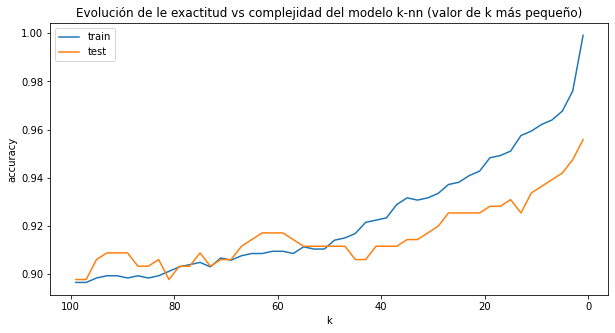

In [50]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.plot(k_vec, vec_train)
plt.plot(k_vec, vec_test)
ax.set_xlim(ax.get_xlim()[::-1])
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Evolución de le exactitud vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['train', 'test'])
plt.show()

In [51]:
# The best k is 60
knn = KNeighborsClassifier(n_neighbors=60)
knn.fit(data_train_prep, y_train_prep)
y_pred_knn = knn.predict(data_test_prep)

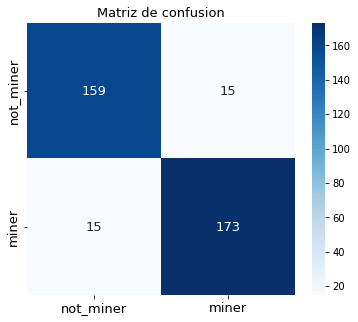

In [52]:
matrix_knn = consufion_matrix(y_test_prep, y_pred_knn, **{'miner':1, 'not_miner':0})

In [53]:
accuracy, kappa, precision, recall, f1_score = metricas(y_test_prep, y_pred_knn, matrix_knn)
met_knn = [accuracy, kappa, precision, recall, f1_score ]

Accuracy  :   0.917
Kappa     :   0.834
predicción Miners
Precision:   0.920
Recall    :   0.920
F1-score   :   0.920


- El modelo KNN tiene un buen rendimiento a la hora de predecir trafico minero y normal, la exacctitud es 92%
- El indice del kappa indica que los estimadores están deacuerdo, y la suerte es de un 17%

In [54]:
tree_desition = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [55]:
tree_desition.fit(data_train_prep, y_train_prep)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

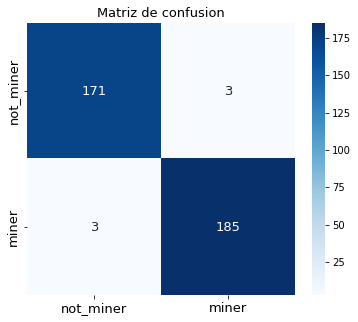

In [56]:
y_pred_tree = tree_desition.predict(data_test_prep)
matrix_tree = consufion_matrix(y_test_prep, y_pred_tree, **{'miner':1, 'not_miner':0})

In [57]:
accuracy, kappa, precision, recall, f1_score = metricas(y_test_prep, y_pred_tree, matrix_tree)
met_dte = [accuracy, kappa, precision, recall, f1_score ]

Accuracy  :   0.983
Kappa     :   0.967
predicción Miners
Precision:   0.984
Recall    :   0.984
F1-score   :   0.984


- El modelo arbol tiene un buen rendimiento a la hora de predecir trafico minero y normal, la exacctitud es 99%
- El indice del kappa indica que los estimadores están deacuerdo en un 97%, y la suerte tiene una probabilida del 3%

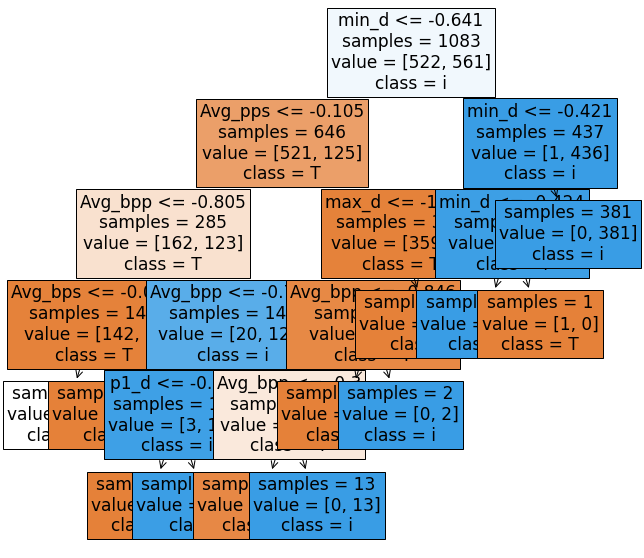

In [58]:
fig, ax = plt.subplots(figsize = (10,10))

plot_tree(
    decision_tree = tree_desition,
    feature_names = data_train_prep.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

plt.show()

In [59]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [63]:
def model_deep():
  deep = Sequential()
  deep.add(Dense(5, input_dim=8, activation='relu', kernel_initializer='glorot_uniform'))
  deep.add(Dense(5, activation='relu', kernel_initializer='glorot_uniform'))
  deep.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
  deep.compile(loss="binary_crossentropy", optimizer='adam')
  return deep

In [64]:
model = KerasClassifier(build_fn=model_deep, epochs = 100, batch_size=5, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [65]:
history = model.fit(data_train_prep, y_train_prep, validation_data = (data_test_prep, y_test_prep))

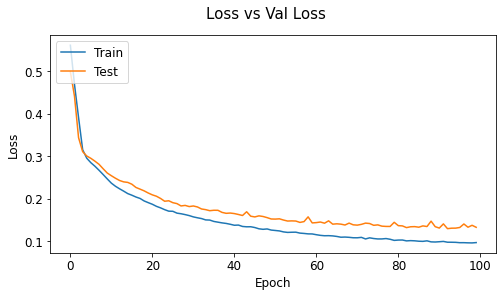

In [66]:
optimization_learning_curves(history, metrica='loss', title='Loss vs Val Loss')

In [67]:
y_predict_deep = model.predict((data_test_prep)>0.5).astype('int32')
y_predict_deep = np.reshape(y_predict_deep, y_predict_deep.shape[0])
y_predict_deep

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,

Accuracy  :   0.738
Kappa     :   0.463
predicción Miners
Precision:   0.664
Recall    :   1.000
F1-score   :   0.798


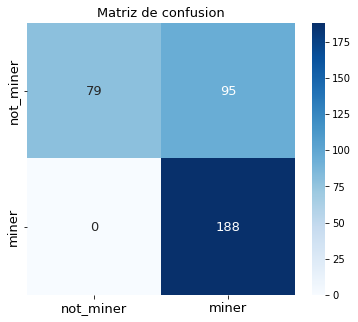

In [68]:
matrix_deep = consufion_matrix(y_test_prep, y_predict_deep, **{'miner':1, 'not_miner':0})
accuracy, kappa, precision, recall, f1_score = metricas(y_test_prep, y_predict_deep, matrix_deep)
met_deep = [accuracy, kappa, precision, recall, f1_score ]

- El modelo red neuronal tiene un buen rendimiento a la hora de predecir trafico minero y normal, pero por debajo del KNN y el arbol de decición,  la exacctitud es de 81%
- El indice del kappa indica que los estimadores están deacuerdo 64%, y la suerte es de un 36%

In [69]:
def ROC(X_test,y_test,model):
    y_pred_proba = model.predict_proba(X_test)
    model_probs = y_pred_proba[:,1]
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = metrics.roc_auc_score(y_test, ns_probs)
    model_auc = metrics.roc_auc_score(y_test, model_probs)
    ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
    model_fpr, model_tpr, thresholds = metrics.roc_curve(y_test, model_probs)
    return ns_fpr, ns_tpr, model_fpr, model_tpr, model_auc

In [70]:
ns_fpr, ns_tpr, knn_fpr, knn_tpr, knn_auc = ROC(data_test_prep,y_test_prep,knn)
_, _, tree_desition_fpr, tree_desition_tpr, tree_auc = ROC(data_test_prep,y_test_prep,tree_desition)
_, _, deep_desition_fpr, deep_desition_tpr, deep_auc = ROC(data_test_prep,y_test_prep,model)

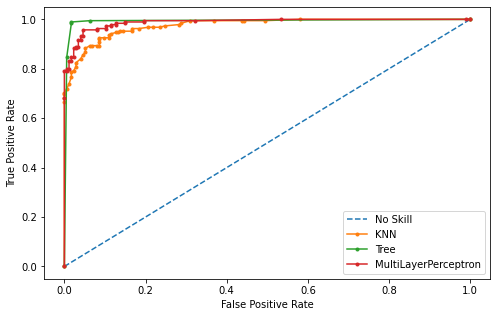

In [71]:
plt.subplots(figsize=(8,5))
plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
plt.plot(tree_desition_fpr, tree_desition_tpr, marker='.', label='Tree')
plt.plot(deep_desition_fpr, deep_desition_tpr, marker='.', label='MultiLayerPerceptron')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [72]:
print(f'El arbol tiene un area de la curva de {tree_auc} superior al {knn_auc} del knn y superior al  {deep_auc}')

El arbol tiene un area de la curva de 0.9928466617754953 superior al 0.9759262655906089 del knn y superior al 0.9886127415015896


# Análizando metricas

In [73]:
metricasDF = pd.DataFrame()
metricasDF

""


In [74]:
metricasDF['KNN'] = met_knn

In [75]:
metricasDF['Tree'] = met_dte

In [76]:
metricasDF['MultiLayerPerceptron'] = met_deep

In [77]:
metricasDF.index = ['accuracy', 'kappa', 'precision', 'recall', 'f1_score ']

In [78]:
metricasDF

,KNN,Tree,MultiLayerPerceptron
accuracy,0.917,0.983,0.738
kappa,0.834,0.967,0.463
precision,0.920,0.984,0.664
recall,0.920,0.984,1.000
f1_score,0.920,0.984,0.798


El modelo que tiene mayor habilidad para predecir si el tráfico es normal o minero es el árbol de decisión. También se validó el kappa, para medir la concordancia de los estimadores de predicción y realidad, métrica cuyo fuerza de concordancia es mayor en el árbol de decisión. En general, el resto de métricas son bastante buenas en el árbol de clasificación. Ahora existe la probabilidad que el modelo no se halla ajustado, sino que los datos tengan una complejidad mínima, se tiene que recordar que los datos utilizados son un resumen de los datos de la sonda nfdum. 

In [80]:
from sklearn.model_selection import GridSearchCV, cross_val_score


In [83]:
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
tree = DecisionTreeClassifier()
tree = GridSearchCV(tree, param_grid, cv=10, return_train_score=True)
tree.fit(data_train_prep, y_train_prep)


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             return_train_score=True)

In [85]:
print('Mejor: %f usando %s' % (tree.best_score_, tree.best_params_))

Mejor: 0.989840 usando {'criterion': 'entropy', 'max_depth': 8}


In [88]:
model_final = tree.best_estimator_
model_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [105]:
def sesgo_prediction(prediction, validation):
  average_prediction = (len(prediction[prediction==1])/len(prediction))
  average_label_target = (len(validation[validation==1]) / len(validation)) 
  sesgo_prediction = average_prediction - average_label_target
  return sesgo_prediction, average_prediction, average_label_target

In [104]:
model_final.fit(data_train_prep, y_train_prep)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

In [96]:
y_pred_tree = model_final.predict(data_test_prep)

In [109]:
sesgo, promedio_prediccion, promedio_validacion = sesgo_prediction(y_pred_tree, y_test_prep)
print(f'Promedio de predicciones:  {promedio_prediccion}')
print(f'Promedio de etiquetas: {promedio_validacion}')
print(f'Sesgo de predicción: {sesgo}')

Promedio de predicciones:  0.5193370165745856
Promedio de etiquetas: 0.5193370165745856
Sesgo de predicción: 0.0


El sesgo de predicción es minimo

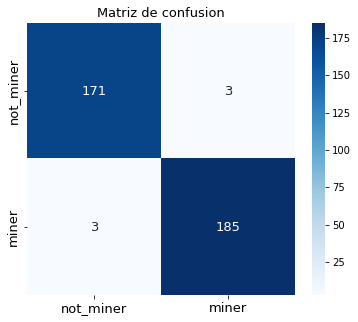

In [102]:
matrix = consufion_matrix(y_test_prep, y_pred_tree, **{'miner':1, 'not_miner':0})

In [103]:
accuracy, kappa, precision, recall, f1_score = metricas(y_test_prep, y_pred_tree, matrix)

Accuracy  :   0.983
Kappa     :   0.967
predicción Miners
Precision:   0.984
Recall    :   0.984
F1-score   :   0.984
